Which file would you like to open?
1. M52_Measurements.xls
2. M39_Measurements.xls
3. M15_Measurements.xls

Enter the number corresponding to your choice: 1
You selected to view data for: M52/NGC 7654

Label                 B         V  FluxRatio       Bmag       Vmag       B_V
rel_flux_T2    0.064585  0.072414   0.891886  12.385671  11.856444  0.529227
rel_flux_T3    0.107069  0.197407   0.542377  11.836841  10.767594  1.069247
rel_flux_T4    0.113531  0.210676   0.538889  11.773214  10.696962  1.076252
rel_flux_T5    1.072364  1.868409   0.573945   9.335144   8.327320  1.007824
rel_flux_T6    2.103930  2.675774   0.786288   8.603422   7.937376  0.666045
...                 ...       ...        ...        ...        ...       ...
rel_flux_T126  0.023164  0.028184   0.821885  13.498966  12.880993  0.617973
rel_flux_T127  0.024529  0.026403   0.929023  13.436800  12.951867  0.484934
rel_flux_T128  0.049045  0.057646   0.850796  12.684513  12.104077  0.580436
rel_flux_T129  0.015887  0.0

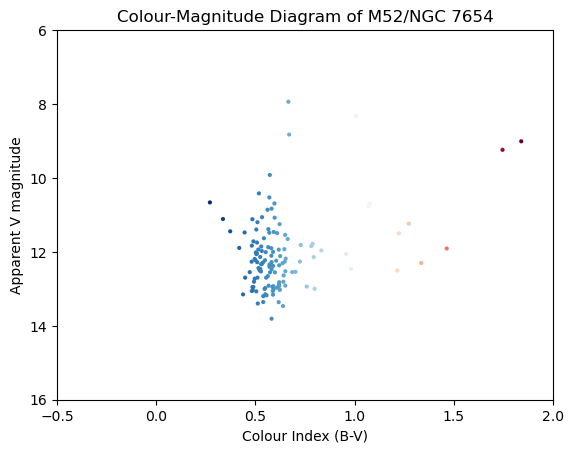

In [1]:
# First import the packages that we will need
import pandas as pd
import re     # for Regular expressions
import os
import matplotlib.pyplot as plt
import numpy as np
import math


# Define helper function for reading in required columns
# pd.read_csv calls this once for each column - returns True
# if we want to include this column, and False if not wanted
# (this allows us to include the relative flux columns
#  and to exclude the rel-flux_err columns that contain error values)
def isValidCol(colName):
    return (colName[0:10] == 'rel_flux_T' or colName == 'Label')

    
# Prompts the user to choose a file from a list of three options and 
# then returns the file name
def open_prompt(cluster_data):
    print("Which file would you like to open?")

    for i, obj in enumerate(cluster_data, start=1):
        # We are going to assume that each cluster object has a property called 'fileName'
        print(f"{i}. {obj.get('fileName')}")         
            
    while True:
        try:
            # Get user input
            user_choice = int(input("\nEnter the number corresponding to your choice: "))
                        
            if 1 <= user_choice <= len(cluster_data):
                selected_cluster = cluster_data[user_choice - 1]
                #print(selected_cluster)
                
                print(f"You selected to view data for: {selected_cluster.get('name')}\n")
                
                # we are assuming the path to the file is the same as this script
                file_name = selected_cluster.get("fileName")

                if not os.path.exists(file_name):
                    print(f"The data file '{file_name}' does not exist. Please fix this before carrying on.\n")

                return selected_cluster
            else:
                print("Invalid choice. Please enter a number between 1 and 3.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")
            

# This is our dataset for the notebook. Each ClusterInfo object
# provides the name of the cluster (used on the plot), the observational
# data filename, and the reference star B and V magnitudes. Adjust this
# as needed. Some of this data is taken from Table 3.2 in PIRATE Week 3
cluster_data = [ 
    { "name": "M52/NGC 7654", "fileName": "M52_Measurements.xls", "refStarBMag": 9.411, "refStarVMag": 9.006 },
    { "name": "M39/NGC 7092", "fileName": "M39_Measurements.xls", "refStarBMag": 10.309, "refStarVMag": 10.067 },
    { "name": "M15/NGC 7078", "fileName": "M15_Measurements.xls", "refStarBMag": 10.928, "refStarVMag": 10.378 }
]
     
# Prompt the user for a filename
selected_cluster = open_prompt(cluster_data)

# Read data from the file into a Pandas DataFrame
ClusterData = pd.read_csv(selected_cluster.get('fileName'), sep = '\t', usecols = isValidCol)
#print(ClusterData)

# The first row of the dataset contains column headings
# Subsequent rows contain the photometry results from each image
# Normally there will be two rows - one for the B filter and one for the V filter
# The next step is to identify which row is which. This can be done using regular expressions.

# First, define a search string to isolate 'B' or 'V' in the correct place
# The image name will contain either "Filter_B" or "Filter_V"
# r at the start of the string defines a raw string (need for regular expression)
pattern_matcher = r'.*_([BV]).*' # r'.*Filter_([BV])_.*'

# Assuming this will ALWAYS match, replace image name with either 'B' or 'V'
ClusterData['Label'] = ClusterData['Label'].str.extract(pattern_matcher)

# The label column now contains just 'B' or 'V' - we can use this as an index
ClusterData.set_index('Label', inplace = True)
#print(ClusterData)

# Finally, transpose from rows to columns - this makes it easier to work with the dataset
ClusterData = ClusterData.transpose()
# print(ClusterData)

# This step is not needed for the calculations in Activity 6.4
# It is simply an illustration of how to carry out calculations and 
# add columns to the dataset
ClusterData['FluxRatio'] = ClusterData['B']/ClusterData['V']
# print(ClusterData)

# Magnitudes of our reference star with the catalogue B and V values
REF_B_MAG = selected_cluster.get('refStarBMag')
REF_V_MAG = selected_cluster.get('refStarVMag')

# Calculate the magnitudes and colour index (B-V)
ClusterData['Bmag'] = (-2.5) * np.log10(ClusterData['B']) + REF_B_MAG                    
ClusterData['Vmag'] = (-2.5) * np.log10(ClusterData['V']) + REF_V_MAG                      
ClusterData['B_V']  = ClusterData['Bmag'] - ClusterData['Vmag']                    
print(ClusterData)

# Now that we have our ClusterData, let us set up our plots

# Create a plot of the V magnitude against the colour index (B-V)
# We can specify a colour-map for our scatter plot, to start I have chosen RedBlue reverse
plt.scatter(ClusterData['B_V'], ClusterData['Vmag'], alpha=1.0, c=ClusterData['B_V'], marker='.', edgecolors='none', cmap='RdBu_r')
# plt.scatter(ClusterData['B_V'], ClusterData['Vmag'], alpha=0.5, marker='.', edgecolors='none')

# Set the plot properties using the selected cluster
plt.title(f"Colour-Magnitude Diagram of {selected_cluster.get('name')}")
plt.xlabel('Colour Index (B-V)')
plt.ylabel('Apparent V magnitude')
plt.ylim(16,6)
plt.xlim(-0.5,2)

# Show the plot
plt.show()